In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mgimg
import scipy as sp
import numpy as np
import cPickle as pickle
from scipy import interpolate
from scipy.interpolate import interp1d
from IPython.display import display
%matplotlib inline
#%config InlineBackend.close_figures = False
from scipy.io.idl import readsav
from astropy.convolution import convolve, convolve_fft
from astropy.convolution import Gaussian1DKernel
from pysynphot import observation
from pysynphot import spectrum
import forwardmodel
import ciamod

/Users/bb/Library/Python/2.7/lib/python/site-packages/pysynphot/locations.py:14: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/bb/Library/Python/2.7/lib/python/site-packages/pysynphot/locations.py:74: UserWarning: Extinction files should be moved to $PYSYN_CDBS/extinction for compatibility with future versions of pysynphot.
  warnings.warn('Extinction files should be moved to '
/Users/bb/Library/Python/2.7/lib/python/site-packages/pysynphot/locations.py:110: UserWarning: Extinction files not found in grid/extinction
  warnings.warn('Extinction files not found in %s' % (extdir,))
/Users/bb/Library/Python/2.7/lib/python/site-packages/pysynphot/locations.py:88: UserWarning: PYSYN_CDBS is undefined; cannot find mtab/*_tmg.fits file
  warnings.warn("PYSYN_CDBS is undefined; cannot find %s file" % template)
/Users/bb/Library/Python/2.7/lib/python/site-packages/pysynphot/location

In [2]:
array = pickle.load(open("test_H2H2_H2He_CIA_H2O.pic", "rb")) 
leveltemp = array[0]
levelpress = array[1]
mikespec = np.array([array[2],array[3]],dtype='f')
mikespec[0] = 10000.0 / mikespec[0]
print levelpress.size
print levelpress

80
[  9.99999975e-05   1.20226425e-04   1.44543999e-04   1.73780092e-04
   2.08929574e-04   2.51188700e-04   3.01995198e-04   3.63077997e-04
   4.36515693e-04   5.24807489e-04   6.30957249e-04   7.58577778e-04
   9.12010903e-04   1.09647808e-03   1.31825637e-03   1.58489251e-03
   1.90546061e-03   2.29086843e-03   2.75422912e-03   3.31131113e-03
   3.98107106e-03   4.78629908e-03   5.75439911e-03   6.91830833e-03
   8.31763912e-03   9.99999978e-03   1.20226424e-02   1.44543927e-02
   1.73780080e-02   2.08929572e-02   2.51188558e-02   3.01995184e-02
   3.63078006e-02   4.36515696e-02   5.24807498e-02   6.30957261e-02
   7.58577362e-02   9.12010893e-02   1.09647810e-01   1.31825641e-01
   1.58489242e-01   1.90546066e-01   2.29086712e-01   2.75422752e-01
   3.31131101e-01   3.98107082e-01   4.78629917e-01   5.75439930e-01
   6.91830814e-01   8.31763446e-01   1.00000000e+00   1.20226419e+00
   1.44543922e+00   1.73779988e+00   2.08929467e+00   2.51188707e+00
   3.01995182e+00   3.63077998e

In [3]:
# set up coarse pressure grid and fine pressure grid
logcoarsePress = np.arange(-4.0, 2.5, 0.5)
coarsePress = pow(10,logcoarsePress)
logfinePress = np.arange(-4.0, 2.5, 0.1)
finePress = pow(10,logfinePress)
print finePress.size
print coarsePress.size
print finePress

65
13
[  1.00000000e-04   1.25892541e-04   1.58489319e-04   1.99526231e-04
   2.51188643e-04   3.16227766e-04   3.98107171e-04   5.01187234e-04
   6.30957344e-04   7.94328235e-04   1.00000000e-03   1.25892541e-03
   1.58489319e-03   1.99526231e-03   2.51188643e-03   3.16227766e-03
   3.98107171e-03   5.01187234e-03   6.30957344e-03   7.94328235e-03
   1.00000000e-02   1.25892541e-02   1.58489319e-02   1.99526231e-02
   2.51188643e-02   3.16227766e-02   3.98107171e-02   5.01187234e-02
   6.30957344e-02   7.94328235e-02   1.00000000e-01   1.25892541e-01
   1.58489319e-01   1.99526231e-01   2.51188643e-01   3.16227766e-01
   3.98107171e-01   5.01187234e-01   6.30957344e-01   7.94328235e-01
   1.00000000e+00   1.25892541e+00   1.58489319e+00   1.99526231e+00
   2.51188643e+00   3.16227766e+00   3.98107171e+00   5.01187234e+00
   6.30957344e+00   7.94328235e+00   1.00000000e+01   1.25892541e+01
   1.58489319e+01   1.99526231e+01   2.51188643e+01   3.16227766e+01
   3.98107171e+01   5.011872

In [4]:
mikepress = np.empty(levelpress.size - 1,dtype='float64')
miketemp = np.empty(leveltemp.size -1, dtype='float64')
for i in range(0,mikepress.size):
    mikepress[i] = np.sqrt(levelpress[i] * levelpress[i+1])
mtfit = interp1d(np.log10(levelpress),leveltemp)
miketemp = mtfit(np.log10(mikepress)) 
tfit = interp1d(np.log10(mikepress),miketemp,bounds_error=False,fill_value=miketemp[miketemp.size-1])
temp = tfit(np.log10(finePress))

In [7]:
# Get the linelists
ngas = 5
gasnum = np.asfortranarray(np.array([1,2,20,4,5],dtype='i'))
lists = ["../Linelists/xsecarrH2O_1wno_500_10000.save","../Linelists/xsecarrCH4_1wno_500_10000.save","../Linelists/xsecarrK_new_1wno_500_10000_02.save","../Linelists/xsecarrCO_1wno_500_10000_02.save","../Linelists/xsecarrCO2_1wno_500_10000_02.save" ]

In [8]:
x=readsav('../Linelists/xsecarrH2O_1wno_500_10000.save')
inlinelist=x.xsecarr  #3D array with Nwavenubmers x Ntemps x Npressure
inlinetemps=np.asfortranarray(x.t,dtype='float64')
inpress=x.p
inwavenum=x.wno
ntemps = inlinetemps.size
npress= finePress.size
nwave = inwavenum.size
#logpress = np.arange(-5.,2.5,0.125)
#press = 10.**logpress
#print press
# Here we are interpolating the linelist onto our fine pressure scale. 
linelist = (np.ones([ngas,npress,ntemps,nwave],order='F')).astype('float64', order='F')
for gas in range (0,ngas):
    inlinelist=readsav(lists[gas]).xsecarr
    for i in range (0,ntemps):
        for j in range (0,nwave):
            pfit = interp1d(np.log10(inpress),np.log10(inlinelist[:,i,j]))
            linelist[gas,:,i,j] = np.asfortranarray(pfit(np.log10(finePress)))
#print linelist.shape
#print np.result_type(linelist)
press = finePress*1000.

In [9]:
#intemp = np.loadtxt("16temps.dat",dtype='float32')
#intemp = np.full(16,1000.,dtype='f')
#inlayer = np.arange(0,15.25,1)  
#layer = np.arange(0,15.00,0.25)
#print layer.size
#tfit = interpolate.splrep(inlayer,intemp,s=0)
#temp = np.asfortranarray(interpolate.splev(layer,tfit, der=0),dtype='float32')
w1 = 1.05
w2 = 5.0
logg = 4.5
R2D2 = 1.0
#print inpress
#print mikepress

In [10]:
VMR1 = np.full((npress,),(-3.5)) # water
vmr2 = np.full((npress,),(-3.4)) # ch4
vmr3 = np.full((npress,),(-8.0))  # K
vmr4 = np.full((npress,),(-7.5)) # CO
vmr5 = np.full((npress,),(-8.2)) # CO2
#print VMR1.shape
logVMR = np.asfortranarray(np.reshape((VMR1,vmr2,vmr3,vmr4,vmr5),(ngas,npress)),dtype='float64')
print logVMR.shape

(5, 65)


In [11]:
pcover = 1.0
do_clouds = 0
cloudnum = np.array([1],dtype='i')
#cloudname = np.reshape((cname),(1,1))
cloudrad = np.full((1,npress,1),1e-4)
cloudsig = np.full((1,npress,1),1e-5)
cloudprof = np.full((1,npress,1),0.0)

In [12]:
cia, ciatemps = ciamod.read_cia("CIA_DS_aug_2015.dat",inwavenum)
cia = np.asfortranarray(cia, dtype='float32')
ciatemps = np.asfortranarray(ciatemps, dtype='float32')
print cia.shape
print ciatemps.shape
print cia.dtype

(4, 198, 9501)
(198,)
float32


In [13]:
outspec = forwardmodel.marv(w1,w2,temp,logg,R2D2,gasnum,logVMR,pcover,do_clouds,cloudnum,cloudrad,cloudsig,cloudprof,inlinetemps,press,inwavenum,linelist,cia,ciatemps)

In [ ]:
#np.savetxt("disort16stream_test.dat",np.c_[outspec[0,:],outspec[1,:]])

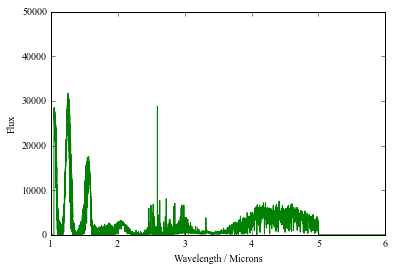

In [14]:
B = np.empty(nwave,dtype='d') 
B = 3.14159274*((2.*6.62606957e-34*(2.99792458e8**2.)) / ((outspec[0,:]*1.e-6)**5.)) / ((np.exp((6.62606957e-34*2.99792458e8)/(outspec[0,:]*1e-6*1.3806488e-23*1000.)))-1.) * 1.e-6
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([1.0, 6.0,0.0,5e4])
#plt.plot(outspec[0,:],(outspec[1,:] / B),'r-')
#plt.plot(outspec[0,:],B,'b-')
plt.plot(outspec[0,:],outspec[1,:],'g-')
#plt.plot(mikespec[0,:],outspec[1,:] / (mikespec[1,:]/1e6),'r-')
#plt.plot(mikespec[0,:],((mikespec[1,:] / 1e6) / outspec[1,:]), 'r-')
#plt.plot(outspec[0,:],np.full(nwave,1.0),'b--')

#plt.plot(outspec[0,:],6.666*outspec[1,:],'b-')
plt.ylabel(r'Flux')
plt.xlabel('Wavelength / Microns')

#asp = 10 / 3.5

#plt.axes().set_aspect(asp)
plt.savefig('testspec.pdf',format='pdf', dpi=720)

In [15]:
outspec =  outspec[:,np.logical_not(np.logical_or(outspec[0,:] > w2, outspec[0,:] < w1))]
wlen = outspec.shape[1]
wint = outspec[0,0] - outspec[0,wlen-1]
disp = wint / wlen
fwhm = 0.005
gwidth = int(round(fwhm / disp))

In [16]:
mikespec[1,:] = mikespec[1,:] / 1e6
mikespec =  mikespec[:,np.logical_not(np.logical_or(mikespec[0,:] > w2, mikespec[0,:] < w1))]
wlen = mikespec.shape[1]
wint = mikespec[0,0] - mikespec[0,wlen-1]
disp = wint / wlen
fwhm = 0.005
gwidth = int(round(fwhm / disp))

In [17]:
from astropy.convolution import convolve, convolve_fft
from astropy.convolution import Gaussian1DKernel


In [18]:
gauss = Gaussian1DKernel(gwidth)
cspec = convolve(outspec[1,:],gauss,boundary='extend')
spec = np.array([outspec[0,:],cspec])

In [19]:
mgauss = Gaussian1DKernel(gwidth)
mcspec = convolve(mikespec[1,:],mgauss,boundary='extend')
mspec = np.array([mikespec[0,:],mcspec])

In [20]:
print mspec[1]
print spec[1]

[   6226.65136719    6184.72851562    6140.03173828 ...,  136679.578125
  136766.140625    136847.609375  ]
[  2816.60763951   2788.48876075   2758.97527169 ...,  27655.2277826
  27677.33385172  27699.62311423]


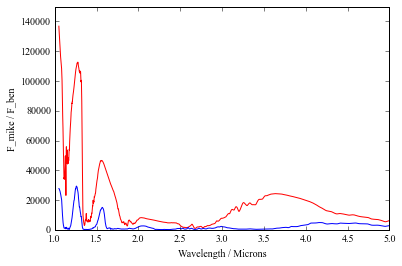

In [26]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([1.0, 5.0, 0.,1.5e5])
plt.plot(mspec[0,:],mspec[1,:],'r-')
plt.plot(spec[0,:],spec[1,:],'b-')
#plt.plot(spec[0,:],mspec[1,:] / spec[1,:],'g-')
plt.ylabel(r'F_mike / F_ben')
plt.xlabel('Wavelength / Microns')


In [22]:
# now rebin
wavenew = np.arange(w1,w2,0.0015,dtype='f')
ispec = spectrum.ArraySourceSpectrum(wave=spec[0,:], flux=spec[1,:])
f = np.ones(len(spec[0,:]))
filt = spectrum.ArraySpectralElement(spec[0,:], f, waveunits='microns')
obs = observation.Observation(ispec, filt, binset=wavenew, force='taper')
print obs.binflux.shape

(2634,)


In [23]:
speclen = obs.binflux.size
unc = np.max(obs.binflux)
error = np.full(speclen,unc/50)
outflux = np.ones(speclen)
outflux = obs.binflux + error*np.random.randn(speclen)
    

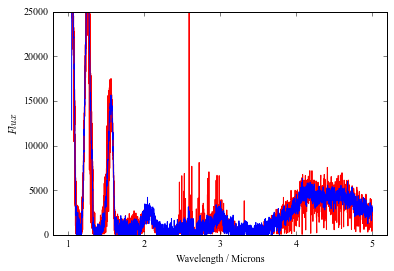

In [27]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0.8, 5.2, 0.,25000])
plt.plot(outspec[0,:],outspec[1,:],'r-')
#plt.plot(spec[0,:],spec[1,:],'b-')
plt.plot(wavenew,outflux,'b-')
plt.ylabel(r'$Flux$')
plt.xlabel('Wavelength / Microns')


In [25]:
np.savetxt('5gas_spectrum.dat', np.c_[wavenew,outflux,error])

In [ ]:
gwidth = 4
if (gwidth % 2 == 0):
    gwidth = gwidth + 1

In [ ]:
print gwidth

In [ ]:
theta = [-3.45, -3.40]
fixvmr = -8.

In [ ]:
test = np.array([theta[0],theta[1], fixvmr]).reshape(3,)
print test

In [ ]:
ndim, nwalkers = 2, 4
p0 = -1.* np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim)) - 3.0
print p0.shape

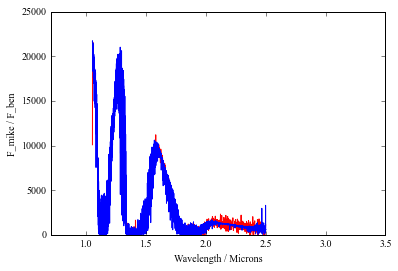

In [31]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0.7, 3.5, 0.,25000])
bspec = np.loadtxt("sim_spectrum.dat", unpack="true")
plt.plot(bspec[0,:],bspec[1,:],'r-')
plt.plot(outspec[0,:],outspec[1,:],'b-')
#plt.plot(spec[0,:],mspec[1,:] / spec[1,:],'g-')
plt.ylabel(r'F_mike / F_ben')
plt.xlabel('Wavelength / Microns')
